In [1]:
from utils import start_notebook
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier,XGBRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
full_data = pd.read_parquet("datasets/tratados/base_completa.parquet")
full_data = full_data.drop(["CO_MUNICIPIO", "SUM_QT_COMP_PORTATIL_ALUNO"], axis =1)


# pegando 90% dos dados para treinar e 10% para validar no final.
train_data = full_data.sample(frac=0.9, random_state=42)
valid_data = full_data.loc[~full_data.index.isin(train_data.index)]

#mostrando o tamanho dos datasets.
print(f"len full data {len(full_data)}")
print(f"len train data {len(train_data)} ")
print(f"len train data {len(valid_data)} ")

# separando a base de teste/treino e a de validação.
y = train_data["MD_NOTA_TOTAL"]
train_data = train_data.drop(["MD_NOTA_TOTAL"], axis = 1)
x = train_data.copy()

len full data 5477
len train data 4929 
len train data 548 


In [3]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
       }


In [10]:
xgbr = xgb.XGBRegressor(seed = 20)

In [11]:
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)

In [12]:
clf.fit(x, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          predictor=None, random_state=None, ...),
                   n_iter=25,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_squared_error', verbose=1)

In [13]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7}
Lowest RMSE:  27.854794366784066


In [14]:
y_valid = valid_data["MD_NOTA_TOTAL"]
valid_data = valid_data.drop(["MD_NOTA_TOTAL"], axis = 1)
x_valid = valid_data.copy()

In [15]:
y_predicted = clf.predict(x_valid)

In [16]:
mse = mean_squared_error(y_predicted ,y_valid)

<AxesSubplot: xlabel='MD_NOTA_TOTAL', ylabel='Count'>

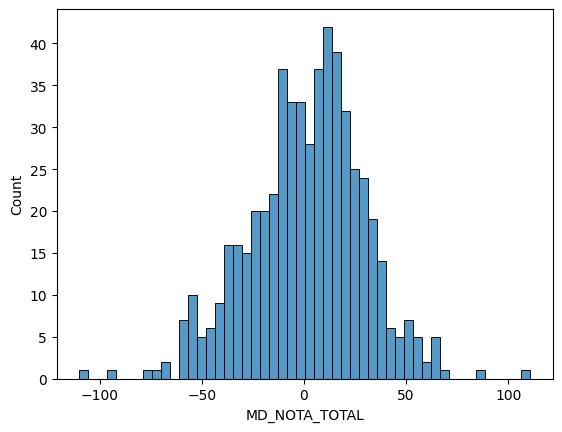

In [27]:
residues = y_predicted - y_valid
sns.histplot(residues, bins=50)

In [18]:
mse

785.293581097095

In [19]:
mse**(1/2)

28.02309014182938

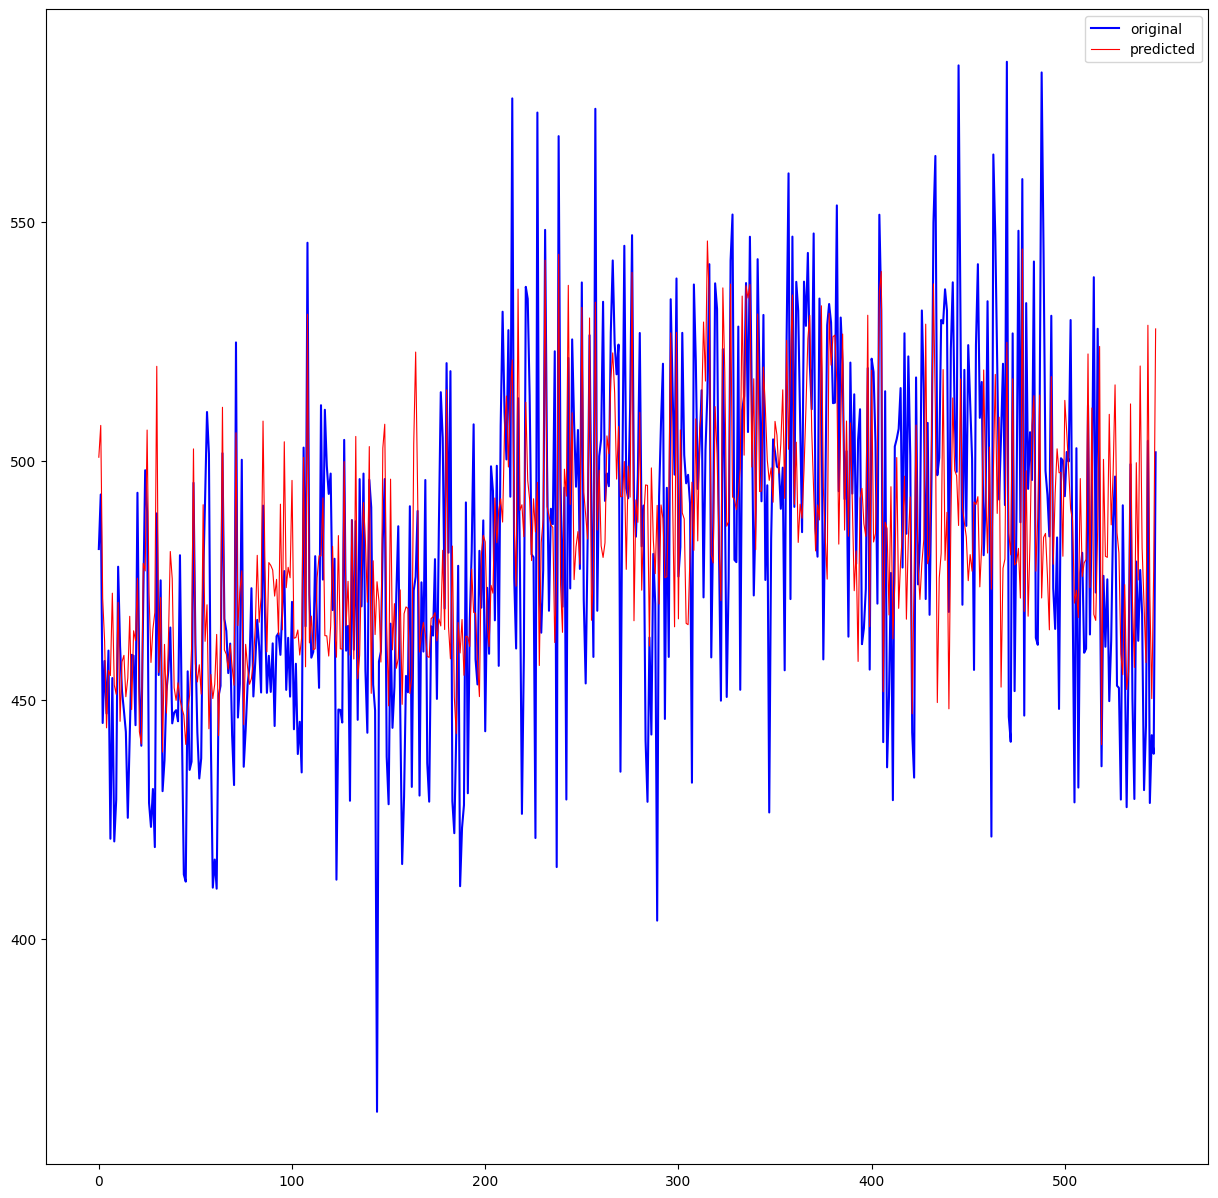

In [23]:
x_ax = range(len(x_valid))
plt.figure(figsize=(15,15))
plt.plot(x_ax, y_valid,  color='blue', label='original' )
plt.plot(x_ax, y_predicted, lw=0.8, color='red', label='predicted')
plt.legend()
plt.show()

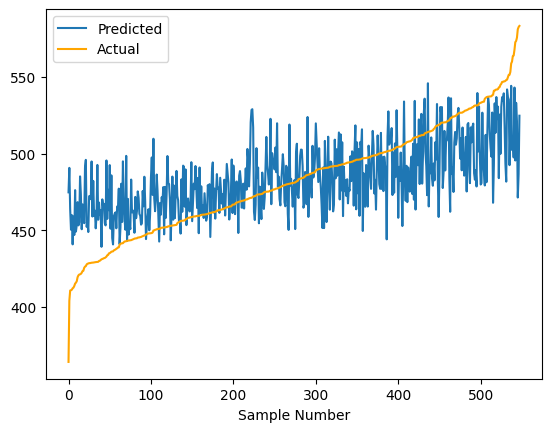

In [24]:
target = pd.Series(y_valid).reset_index(drop=True).sort_values()
predictions = pd.Series(y_predicted)
predictions = predictions.iloc[target.index].reset_index(drop=True)
target = target.reset_index(drop=True)
plt.plot(predictions, label='Predicted')
plt.plot(target, label='Actual', color='orange')
plt.legend(['Predicted', 'Actual'])
plt.xlabel('Sample Number')
plt.show()